In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
meta_data = pd.read_csv('training_set_metadata.csv')
train_series = pd.read_csv('training_set.csv')


In [4]:
meta_data.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


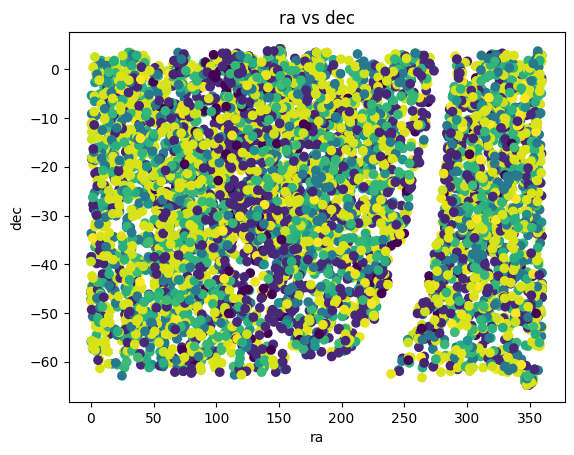

In [5]:

plt.scatter(meta_data['ra'], meta_data['decl'], c=meta_data['target'], cmap='viridis')
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('ra vs dec')
plt.show()

In [6]:
print(meta_data['target'].nunique())
meta_data['target'].unique()

14


array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

In [7]:
targets = np.hstack([np.unique(meta_data['target']), [99]])
target_map = {j:i for i, j in enumerate(targets)}
target_ids = [target_map[i] for i in meta_data['target']]
meta_data['target_id'] = target_ids

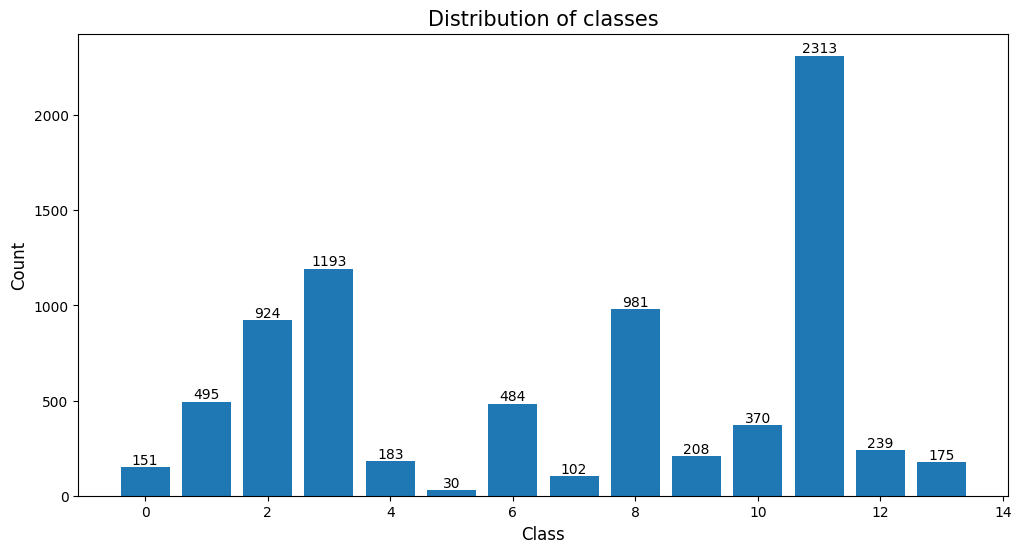

In [8]:
counts = meta_data['target_id'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values)
for x, count in zip(counts.index, counts.values):
    plt.text(x, count, str(count), ha='center', va='bottom', fontsize=10)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of classes', fontsize=15)
plt.show()


In [9]:
train_series.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [10]:
meta_data.object_id.nunique() # num of unique objects

7848

In [11]:
# group by object_id and passband to get the number of observations
num_obs = train_series.groupby(['object_id', 'passband']).size().unstack()
num_obs.columns = ['passband_' + str(col) for col in num_obs.columns]
num_obs = num_obs.reset_index()
num_obs.head()

,object_id,passband_0,passband_1,passband_2,passband_3,passband_4,passband_5
0,615,63,58,58,58,58,57
1,713,70,56,56,56,56,56
2,730,72,52,52,52,51,51
3,745,72,56,56,56,56,55
4,1124,63,58,58,58,58,57


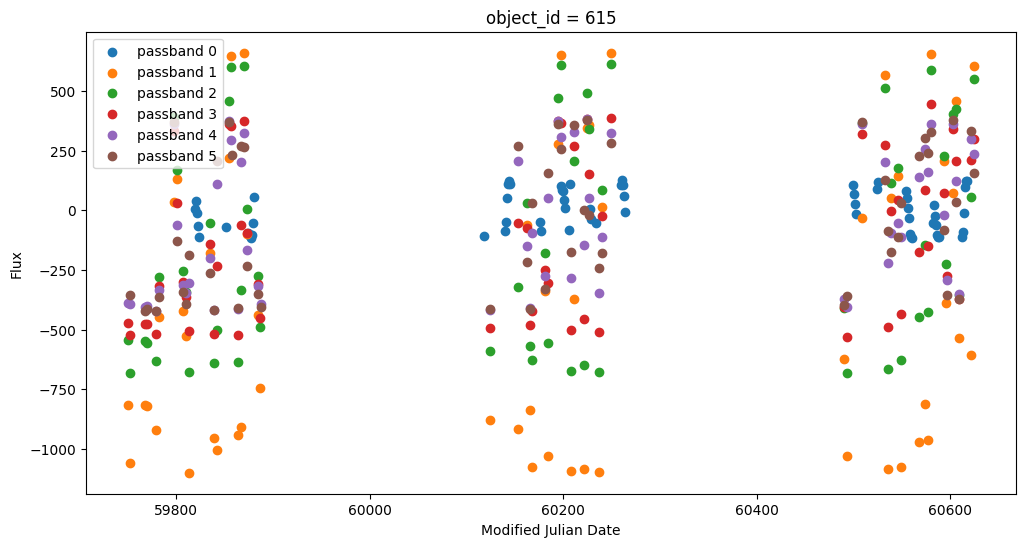

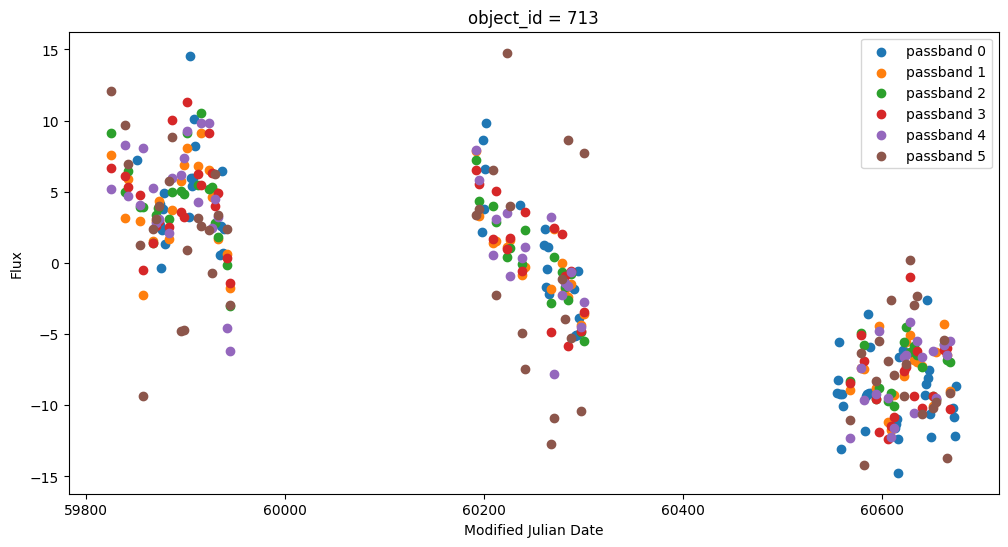

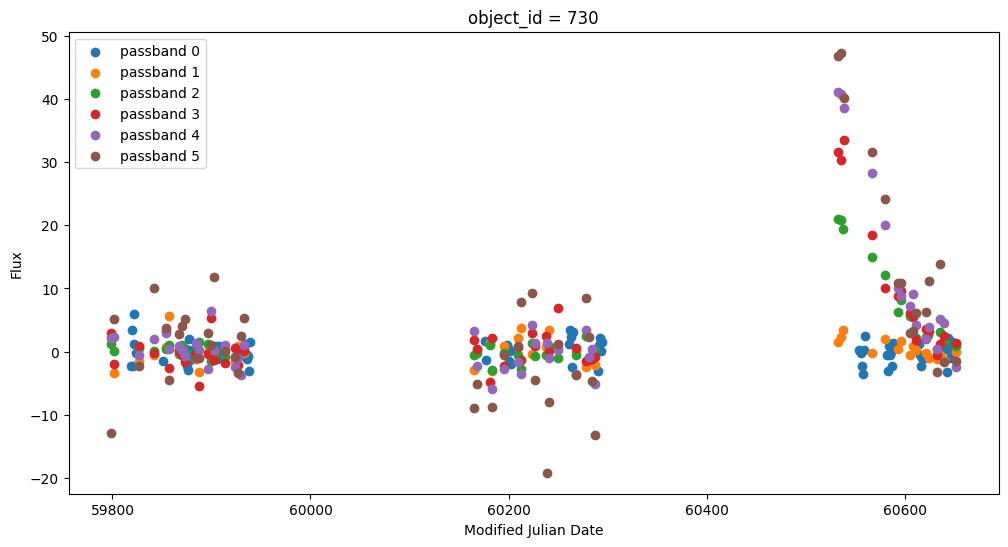

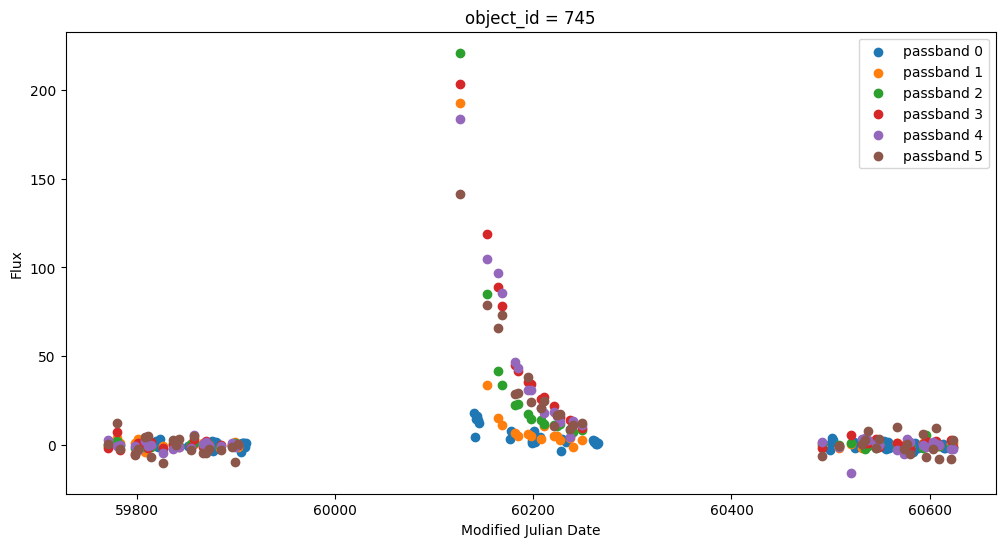

In [12]:
# draw a curve for each object_id with each passband with different color
object_ids = [615, 713, 730, 745]
for object_id in object_ids:
    plt.figure(figsize=(12, 6))
    for i in range(6):
        passband = i
        data = train_series[(train_series.object_id == object_id) & (train_series.passband == passband)]
        plt.scatter(data.mjd, data.flux, label='passband ' + str(passband))
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Flux')
    plt.title('object_id = ' + str(object_id))
    plt.legend()
    plt.show()


In [31]:
# group by object_id and passband to get the mean of flux
mean_flux = train_series.groupby(['object_id', 'passband'])['flux'].mean().unstack()
mean_flux.columns = ['mean_flux_' + str(col) for col in mean_flux.columns]
print(mean_flux.head())

           mean_flux_0  mean_flux_1  mean_flux_2  mean_flux_3  mean_flux_4  \
object_id                                                                    
615          -3.254554  -385.699911  -134.146566  -121.103501   -55.954592   
713          -2.720398    -1.019804    -0.794238    -0.986966    -0.900262   
730          -0.048080     0.141057     2.400870     3.236164     4.308728   
745           1.797523     5.717394     9.711532    14.412924    13.134436   
1124          0.660948     4.634637    10.243968    11.086555     9.906102   

           mean_flux_5  
object_id               
615         -47.449847  
713          -1.794175  
730           4.539396  
745          10.746138  
1124          6.896742  


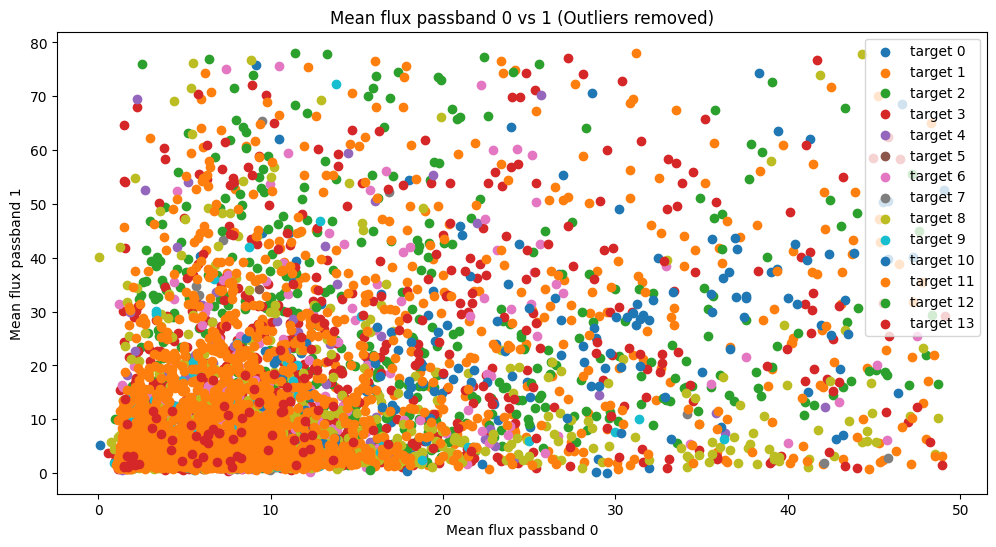

In [36]:
# compute mean flux values per object and passband
mean_flux = train_series[train_series.flux >= 0].groupby(['object_id', 'passband'])['flux'].mean().unstack()
mean_flux.columns = ['mean_flux_' + str(col) for col in mean_flux.columns]

# Remove outliers in mean_flux_0 and mean_flux_1 using the IQR method
flux_vals = mean_flux[['mean_flux_0', 'mean_flux_1']]
q1 = flux_vals.quantile(0.25)
q3 = flux_vals.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Only keep rows that are within bounds for both features
mask = ((flux_vals >= lower_bound) & (flux_vals <= upper_bound)).all(axis=1)
mean_flux_clean = mean_flux[mask]

plt.figure(figsize=(12, 6))
# plot each object with x = mean_flux_0 and y = mean_flux_1, colored by target
for target_id in range(14):
    data_target = meta_data[meta_data.target_id == target_id]
    # consider only object_ids that have cleaned mean fluxes
    valid = data_target['object_id'].isin(mean_flux_clean.index)
    data_target = data_target[valid]
    mf0 = data_target['object_id'].map(mean_flux_clean['mean_flux_0'])
    mf1 = data_target['object_id'].map(mean_flux_clean['mean_flux_1'])
    plt.scatter(mf0, mf1, label='target ' + str(target_id))
plt.legend()
plt.xlabel('Mean flux passband 0')
plt.ylabel('Mean flux passband 1')
plt.title('Mean flux passband 0 vs 1 (Outliers removed)')
plt.show()
